In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q pytorch-lightning transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 KB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 106.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.1 MB/s eta 0:00:00


In [ ]:
!cp /content/drive/MyDrive/Data/ChillantoDataset_nor.zip .
!unzip ChillantoDataset_nor.zip

Archive:  ChillantoDataset_nor.zip
   creating: ChillantoDataset_nor/
  inflating: ChillantoDataset_nor/data_test.csv  
   creating: ChillantoDataset_nor/hunger/
  inflating: ChillantoDataset_nor/hunger/0076006001.wav  
  inflating: ChillantoDataset_nor/hunger/0083026001.wav  
  inflating: ChillantoDataset_nor/hunger/0031002001.wav  
  inflating: ChillantoDataset_nor/hunger/0046009001.wav  
  inflating: ChillantoDataset_nor/hunger/0031005001.wav  
  inflating: ChillantoDataset_nor/hunger/0042003001.wav  
  inflating: ChillantoDataset_nor/hunger/0051006001.wav  
  inflating: ChillantoDataset_nor/hunger/0048003001.wav  
  inflating: ChillantoDataset_nor/hunger/0075002001.wav  
  inflating: ChillantoDataset_nor/hunger/0034007001.wav  
  inflating: ChillantoDataset_nor/hunger/0037007001.wav  
  inflating: ChillantoDataset_nor/hunger/0012002001.wav  
  inflating: ChillantoDataset_nor/hunger/0035005001.wav  
  inflating: ChillantoDataset_nor/hunger/0076001001.wav  
  inflating: ChillantoData

In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
import torchaudio
import torch

import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler
import pytorch_lightning as pl
from transformers import AdamW
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Config, Wav2Vec2Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd   
from glob import glob
from tqdm import tqdm
import torchaudio
import torchmetrics


In [ ]:
label_dir = {
    "asphyxia":0,
    "deaf":1,
    "hunger":2,
    "normal":3,
    "pain":4,
}

In [ ]:
# all_file = glob("ChillantoDataset_nor/*/*.wav")
# all_label = []
# for path in tqdm(all_file):
#     dir_name = path.split("/")[-2]
#     all_label.append(label_dir[dir_name])

# df_train = pd.DataFrame()
# df_train["path"] = all_file
# df_train["label"] = all_label


100%|██████████| 2268/2268 [00:00<00:00, 764377.78it/s]


In [ ]:
# df_train, df_test = train_test_split(df_train,
#                                    random_state=104, 
#                                    test_size=0.3, 
#                                    shuffle=True)
df_train = pd.read_csv('ChillantoDataset_nor/data_train.csv', index_col=None)
df_test = pd.read_csv('ChillantoDataset_nor/data_test.csv', index_col=None)

def get_class_distribution(dataset_obj):
    count_array = np.array([len(np.where(dataset_obj == t)[0]) for t in np.unique(dataset_obj)])
    return count_array

target_list = df_train['label'].values

class_count = np.array([i for i in get_class_distribution(df_train['label'].values)])
weight = 1. / class_count
samples_weight = np.array([weight[t] for t in target_list])
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()

weighted_sampler = WeightedRandomSampler ( 
    weights = samples_weigth, 
    num_samples = len (samples_weigth), 
)

In [ ]:
from random import random, randint

class Random_clip:
    def __init__(self):
        self.len_data = 16000
    def __call__(self,x):
        c, n = x.shape
        if n > self.len_data:
#             print(True)
            n_1 = int(random() * (n - self.len_data))
            return x[:,n_1:n_1+self.len_data]
        else:
            # pad = torch.zeros((c, self.len_data-n), dtype=x.dtype)
            # return torch.concat((x, pad),-1)
            return x
        
    
class Random_Noise:
    def __init__(self):
        self.noise_levels = 0.002
    def __call__(self,x):
        p = random()
        if p > 0.5:
            n = x.shape[-1]
            
            noise = torch.rand((x.shape))*self.noise_levels - self.noise_levels/2
            x = x + noise*x
        return x

class ShiftingTime:
    """Shifting time axis"""
    def __init__(self):
        pass
    
    def __call__(self, x):
        n = x.shape[-1]
        shift_max = randint(0,2)
        if shift_max == 0:
            shift = 0
        else:
            shift = randint(int(n*0.1),int(n*0.2))
        direction = randint(0,2)
        if direction == 1:
            shift = -shift

        x = torch.roll(x, shift)
        return x


class Transform:
    def __init__(self):
        self.stretch = torchaudio.transforms.TimeStretch()
        self.random_clip = Random_clip()
        self.random_noise = Random_Noise()
        self.random_shift = ShiftingTime()
    def __call__(self,x):
        # x = self.stretch(x,)
        x = self.random_clip(x)
        # x = self.random_noise(x)
        # x = self.random_shift(x)
        return x

class TransformVal:
    def __init__(self):
        self.random_clip = Random_clip()
    def __call__(self,x):
        x = self.random_clip(x)
        return x

import torchaudio

class CusttomDataCry:
    def __init__(self, df, processor, transforms=None):
        self.df = df
        self.processor = processor
        self.transforms = transforms

        label_list = sorted(list(set(df.iloc[:,-2])))
        self.label_dir = {k:v for v, k in enumerate(label_list)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx,-2]
        label = self.df.iloc[idx,-1]

        wav, sr = torchaudio.load(path)
        
        wav = torch.mean(wav, dim=0, keepdim=True)
        if self.transforms is not None:
            wav = self.transforms(wav)
        encoded_dict = self.processor(wav[0], sampling_rate=sr, return_tensors="pt", padding="longest", return_attention_mask = True)
        
        input_values = encoded_dict['input_values'][0]
        attention_mask = encoded_dict['attention_mask'][0]

        # print(input_values.shape, label.shape)

        return input_values, attention_mask, label

        # print(wav.shape)

        # wav, sr = torchaudio.load(path)
        # wav = torch.mean(wav, dim=0, keepdim=True)
        # if self.transforms is not None:
        #     wav = self.transforms(wav)
        # # wav = self.random(wav) 

        # encoded_dict = self.processor(wav[0], sampling_rate=sr, return_tensors="pt", padding="longest", return_attention_mask = True)

        # input_values = encoded_dict['input_values'][0]
        # attention_mask = encoded_dict['attention_mask'][0]
        # return input_values, attention_mask, label

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

In [ ]:
# data = CusttomDataCry(df_train, processor, Transform())

In [ ]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from transformers import AdamW
import torch.nn.functional as F

In [ ]:
def soft_cross_entropy(predicts, targets):
            student_likelihood = torch.nn.functional.log_softmax(predicts, dim=-1)
            targets_prob = torch.nn.functional.softmax(targets, dim=-1)
            return (- targets_prob * student_likelihood).mean()


processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

class InputMonitor(pl.Callback):

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # return
        if (batch_idx + 1) % 20 == 0:
            
            x, y, z = batch

            logger = trainer.logger
            logger.experiment.add_histogram("input", x, global_step=trainer.global_step)
            logger.experiment.add_histogram("target", z, global_step=trainer.global_step)

class LitClassification(pl.LightningModule):
    def __init__(self):
        super().__init__()

#         config = Wav2Vec2Config.from_json_file("config.json")

        self.model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=5)


        self.acc = torchmetrics.Accuracy("multiclass", num_classes=5)
        self.f1 = torchmetrics.F1Score("multiclass",num_classes=5, average='macro')
        
#         self.teacher_model.eval()
#         print(self.teacher_model.training)
        self.all_preds = []
        self.all_labels = []
    
    
    def train_dataloader(self):
        datacry = CusttomDataCry(df_train, processor, Transform())
        return DataLoader(datacry, batch_size=32, num_workers=2, sampler = weighted_sampler)
    
    def val_dataloader(self):
        datacry = CusttomDataCry(df_test, processor, TransformVal())
        return DataLoader(datacry, batch_size=16, num_workers=2)
    
    def test_dataloader(self):
        datacry = CusttomDataCry(df_test, processor)
        return DataLoader(datacry, batch_size=16, num_workers=2)
    def configure_optimizers(self):
        optimizer = AdamW(list(self.model.parameters()),
            lr = 2e-5, # args.learning_rate - default is 5e-5,
            eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
        )

        total_steps = len(self.train_dataloader()) * 200

        # Create the learning rate scheduler.
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                        num_warmup_steps = 10, # Default value in run_glue.py
                        num_training_steps = total_steps)
        return [optimizer], [scheduler]
#         return optimizer
    
    def share_batch(self, batch, state):
        input_values, attention_masks, labels = batch
        
#         print(labels)
        
        # print(input_values.shape)
        out = self.model(input_values, 
                        attention_mask=attention_masks, 
                        labels=labels) 
        
        # print("out",out)
        # print("labels", labels)
        # print(labels)
        loss = out.loss
        # print(loss)

        self.log(f"{state}_loss", loss, on_step=False, on_epoch=True)

        acc = self.acc(out.logits, labels)
        f1 = self.f1(out.logits, labels)
        
        # self.log(f'{state}_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        # self.log(f'{state}_f1', f1, on_step=False, on_epoch=True)

        if state == "train":
            acc = self.acc(out.logits, labels)
            self.log(f'{state}_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        elif state == "valid":
            pred = out.logits.argmax(dim=1)
            self.all_preds.append(pred.to('cpu'))
            self.all_labels.append(labels.to('cpu'))

        return loss
    
    def on_validation_epoch_end(self):

        all_preds = torch.cat(self.all_preds,dim=0).to(self.device)
        all_labels = torch.cat(self.all_labels,dim=0).to(self.device)
        # print(all_preds.shape)
        # acc = accuracy(all_preds, all_labels, task="multiclass", num_classes=10)
        # pre = precision(all_preds, all_labels, task="multiclass", average=average, num_classes=10)
        # rec = recall(all_preds, all_labels, task="multiclass", average=average, num_classes=10)
        # f1 = f1_score(all_preds, all_labels, task="multiclass", average=average, num_classes=10)
        acc = self.acc(all_preds, all_labels)
        # print(all_preds.device, all_labels.device)
        f1 = self.f1(all_preds, all_labels)
        
        self.log('valid_acc', acc,  prog_bar=True)
        # self.log('val_pre', pre)
        # self.log('val_rec', rec)
        self.log('valid_f1', f1)
        
        self.all_preds = []
        self.all_labels = []
    
    
    def training_step(self, train_batch, batch_idx):
        loss = self.share_batch(train_batch, "train")
        # print(loss)
        return loss

    def validation_step(self, val_batch, batch_idx):

        loss = self.share_batch(val_batch, "valid")

    def test_step(self, test_batch, batch_idx):

        loss = self.share_batch(test_batch, "test")

In [ ]:
# model_lit = LitClassification()
trainer = pl.Trainer(gpus=1,)
model_lit = LitClassification.load_from_checkpoint("/content/drive/MyDrive/Data/log_baby_cry/train_teacher_model/checkpoints/model.ckpt")
trainer.validate(model_lit)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSequenceClassification: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['projector.bias', 'projector.weight', 'classifier.weight', 'classifier.bias', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be 

Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        valid_acc           0.9515418410301208
        valid_f1            0.9135592579841614
       valid_loss           0.1720452457666397
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid_loss': 0.1720452457666397,
  'valid_acc': 0.9515418410301208,
  'valid_f1': 0.9135592579841614}]

In [ ]:
import torch

class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
model_lit.model

In [ ]:
model_lit.model.eval()
model_lit.model.classifier = Identity()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lit.model.to(device)

model_lit.model.classifier

Identity()

In [ ]:
from tqdm import tqdm
x_train_data = []
y_train_data = []
data_loader = model_lit.train_dataloader()
for _ in range(5):
    for input_values, attention_masks, z in tqdm(data_loader):
        with torch.no_grad():
            input_values = input_values.to(device)
            attention_masks = attention_masks.to(device)
            out = model_lit.model(input_values, 
                    attention_mask=attention_masks,).logits.cpu().numpy()
            x_train_data.extend(out)
            y_train_data.extend(z.numpy())
# x_data = []

100%|██████████| 50/50 [00:06<00:00,  7.20it/s]


In [ ]:
from tqdm import tqdm
x_test_data = []
y_test_data = []
data_loader = model_lit.val_dataloader()
for input_values, attention_masks, z in tqdm(data_loader):
    with torch.no_grad():
        input_values = input_values.to(device)
        attention_masks = attention_masks.to(device)
        out = model_lit.model(input_values, 
                attention_mask=attention_masks,).logits.cpu().numpy()
        x_test_data.extend(out)
        y_test_data.extend(z.numpy())
# x_data = []


100%|██████████| 43/43 [00:03<00:00, 11.32it/s]


(array([1624.,    0., 1559.,    0.,    0., 1572.,    0., 1620.,    0.,
        1560.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

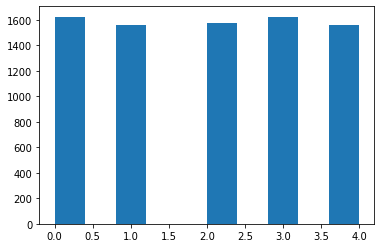

In [ ]:
import matplotlib.pyplot as plt 
plt.hist(y_train_data)

In [ ]:
import numpy as np
from sklearn import svm

In [ ]:
from sklearn.metrics import accuracy_score, f1_score as f1_score_svm

In [ ]:
acc_func = torchmetrics.Accuracy("multiclass", num_classes=5)
f1_func = torchmetrics.F1Score("multiclass",num_classes=5, average='macro')

In [ ]:
# Train a linear SVM classifier
clf = svm.SVC(kernel='linear', C=1)
clf.fit(x_train_data, y_train_data)

# Evaluate the classifier on the test set
y_pred = clf.predict(x_test_data)


accuracy = accuracy_score(y_test_data, y_pred)
f1 = f1_score_svm(y_test_data, y_pred, average="macro")

print("Accuracy: ", accuracy)
print("F1 score: ", f1)

Accuracy:  0.9574155653450808
F1 score:  0.9262221973304353


In [ ]:
# Train a linear SVM classifier
# clf = svm.SVC(kernel='linear', C=1)
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)  
clf.fit(x_train_data, y_train_data)

# Evaluate the classifier on the test set
y_pred = clf.predict(x_test_data)


accuracy = accuracy_score(y_test_data, y_pred)
f1 = f1_score_svm(y_test_data, y_pred, average="macro")

print("Accuracy: ", accuracy)
print("F1 score: ", f1)

Accuracy:  0.9544787077826725
F1 score:  0.9234559700206508
